In [5]:
import os
import sys
sys.path.append("./..")
from utils import PROJECT_ROOT, process_Danenberg_clinical_data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import networkx as nx
from matplotlib.lines import Line2D
import pandas as pd
from c_Population_graph.population_graph import construct_PopulationGraph
from d_Patient_subgroups.community_detection import detect_communities
from e_Survival_analysis.survival_analysis import calculate_hazard_ratio
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test
from f_Prognosis_relevant_patterns_random_split.overpresented_patterns import calculate_relative_presentation

### Parameters

In [6]:
iteration = 2
PhenoGraph_k =  100
node_label = 'CellType'
size_smallest_cluster  = 10
survival_type = 'Disease-specific'
PopulationGraph_type = 'two_step_knn_graph'
para_dict = {
    'weight_threshold_percentile': 50,
    'knn_k': 30
}
patient_filtering_dict = {
}

# Discovery

### Load Gram matrix and clinical data

In [7]:
SoftWL_dict= pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_"
            + node_label
            + ".pkl",
        ),
        "rb",
    ),
)
Patient_IDs = SoftWL_dict["Patient_id"]
Gram_matrix = SoftWL_dict["Gram_matrix"]
Histograms = SoftWL_dict["Histogram"]
Histograms = Histograms/np.sum(Histograms, axis=1, keepdims=True)

clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
clinical = process_Danenberg_clinical_data(clinical)
Patient_Inclusion_mask = np.ones(len(Patient_IDs), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs]
    patient_inclusion_mask = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask = Patient_Inclusion_mask * patient_inclusion_mask
Patient_IDs = np.array(Patient_IDs)[Patient_Inclusion_mask]
Gram_matrix = Gram_matrix[Patient_Inclusion_mask, :][:, Patient_Inclusion_mask]
Histograms = Histograms[Patient_Inclusion_mask, :]
print("{} patients are included".format(len(Patient_IDs)))

379 patients are included


### Clinical Subtype IDs

In [10]:
Community_ids = np.zeros_like(Patient_IDs, dtype=int)
for i in range(len(Patient_IDs)):
    patient_id = Patient_IDs[i]
    clinical_subtype = clinical.loc[clinical['patient_id'] == patient_id, 'Clinical Subtype'].values[0]
    if clinical_subtype == 'HR+/HER2-':
        Community_ids[i] = 1
    elif clinical_subtype == 'HR+/HER2+':
        Community_ids[i] = 2
    elif clinical_subtype == 'HR-/HER2+':
        Community_ids[i] = 3
    elif clinical_subtype == 'TNBC':
        Community_ids[i] = 4


### Survival analysis for subgroups

In [11]:
Length = [clinical.loc[clinical['patient_id'] == i, survival_type+ ' Survival (Months)'].values[0] for i in Patient_IDs]
Status = [clinical.loc[clinical['patient_id'] == i,  survival_type+ ' Survival Status'].values[0] for i in Patient_IDs]  
DF = pd.DataFrame({"Length": Length, "Status": Status, "Community_ids": Community_ids}).dropna()
Length_ = np.array(DF["Length"])
Status_ = np.array(DF["Status"])
Community_ids_ = np.array(DF["Community_ids"])
Histograms_ = Histograms[DF.index.values, :]
Patient_IDs_ = np.array(Patient_IDs)[DF.index.values]
print("{} patients are included".format(len(Patient_IDs_)))
HR = calculate_hazard_ratio(Length_, Status_, Community_ids_)
HR = sorted(HR, key=lambda x: x["hr"], reverse=True)
Subgroup_ids_ = np.zeros_like(Community_ids_)
for i in range(len(HR)):
    Subgroup_ids_[Community_ids_ == HR[i]["community_id"]] = i + 1
    HR[i]["subgroup_id"] = i + 1
for i in range(len(HR)):
    print("S{} (N = {}):".format(HR[i]['subgroup_id'], np.sum(Subgroup_ids_ == HR[i]['subgroup_id'])))
    print("Survival: hr = {}, p = {}".format(HR[i]["hr"], HR[i]["p"]))
    if HR[i]["p"] < 0.05:
        print("\tSignificant")

379 patients are included
S1 (N = 16):
Survival: hr = 3.6071384831138724, p = 5.585215730483297e-05
	Significant
S2 (N = 50):
Survival: hr = 1.8065729111156277, p = 0.01041662638174559
	Significant
S3 (N = 16):
Survival: hr = 1.7293226040065943, p = 0.13421604462705283
S4 (N = 243):
Survival: hr = 0.5869052306914894, p = 0.0027192401578470093
	Significant


In [12]:
def caculate_mutual_similarity(gram_matrix):
    gram_matrix_ = gram_matrix.copy()
    np.fill_diagonal(gram_matrix_, -1)
    return np.mean(gram_matrix_[gram_matrix_!=-1])
for i in range(1, len(HR)+1):
    Gram_matrix_ = Gram_matrix[Subgroup_ids_ == i, :][:, Subgroup_ids_ == i]
    print("{} subgroup {} patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_.shape[0], i, caculate_mutual_similarity(Gram_matrix_)))

print("Overall {} patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix.shape[0], caculate_mutual_similarity(Gram_matrix)))

16 subgroup 1 patients, averaged Intra-group similarity is 0.41 
50 subgroup 2 patients, averaged Intra-group similarity is 0.15 
16 subgroup 3 patients, averaged Intra-group similarity is 0.46 
243 subgroup 4 patients, averaged Intra-group similarity is 0.20 
Overall 379 patients, averaged Intra-group similarity is 0.18 


### Plot hazard ratio

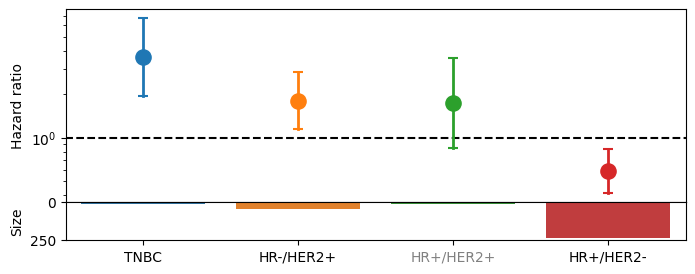

In [21]:
# Plot hazard ratio
num_significant = 0
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
f, ax = plt.subplots(2, 1, height_ratios=[5, 1], figsize=(8, 3), sharex=True)
f.subplots_adjust(hspace=0)
ax[0].hlines(1, -1, len(HR), color="k", linestyle="--")
N, xticklabels, xtickcolors = [], [], []
for i in range(len(HR)):
    hr_dict = HR[i]
    subgroup_id = hr_dict['subgroup_id']
    hr, hr_lb, hr_ub, p = (
            hr_dict["hr"],
            hr_dict["hr_lower"],
            hr_dict["hr_upper"],
            hr_dict["p"],
        )
    ax[0].plot([i, i], [hr_lb, hr_ub], color=color_palette[i], linewidth=2)
    ax[0].scatter([i], [hr], color=color_palette[i], s=120)
    ax[0].scatter([i], [hr_lb], color=color_palette[i], s=60, marker="_")
    ax[0].scatter([i], [hr_ub], color=color_palette[i], s=60, marker="_")
    N.append(np.sum(Subgroup_ids_ == subgroup_id))
    xticklabels.append("S{}".format(int(subgroup_id)))
    if p < 0.05/len(HR):
        xtickcolors.append("k")
        num_significant+=1
    else:
        xtickcolors.append("grey")
ax[0].set_xticks(range(len(HR)))
ax[0].set_xticklabels(xticklabels)
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[0].set_xlabel("Patient Subgroups")
ax[0].set_ylabel("Hazard ratio")
ax[0].set_yscale("log")
# ax[1].set_title("Hazard ratios of Patient Subgroups")
DF = pd.DataFrame({"N": N, "subgroup_id": xticklabels})
g = sns.barplot(data=DF, x="subgroup_id", y="N", palette=color_palette, ax=ax[1])
g.invert_yaxis()
ax[1].set_ylabel("Size")
ax[1].set_xlabel("")
ax[1].set_xticklabels(['TNBC', 'HR-/HER2+','HR+/HER2+','HR+/HER2-'])
plt.show()

### Find overpresented patterns

In [22]:
from f_Prognosis_relevant_patterns_random_split.overpresented_patterns import find_overpresented_patterns
Overpresented_patterns = find_overpresented_patterns(
    Histograms_, Subgroup_ids_, HR, adjust=True
)
print(Overpresented_patterns)


{1: [], 2: [], 4: [33, 2, 8, 9, 12, 17, 21, 22, 25, 26, 27]}


### Plot overpresented patterns

#### Proportion

Subgroup 1
Subgroup 2
Subgroup 4
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

S3 vs. S4: Mann-Whitney-Wilcoxon test two-sided, P_val:9.112e-05 U_stat=8.335e+02
S2 vs. S4: Mann-Whitney-Wilcoxon test two-sided, P_val:1.757e-08 U_stat=3.102e+03
S1 vs. S4: Mann-Whitney-Wilcoxon test two-sided, P_val:8.285e-03 U_stat=1.194e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

S3 vs. S4: Mann-Whitney-Wilcoxon test two-sided, P_val:1.005e-02 U_stat=1.201e+03
S2 vs. S4: Mann-Whitney-Wilcoxon test two-sided, P_val:2.098e-13 U_stat=2.127e+03
S1 vs. S4: Mann-Whitney-Wilcoxon test two-sided, P_val:1.089e-07 U_stat=4.160e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.0

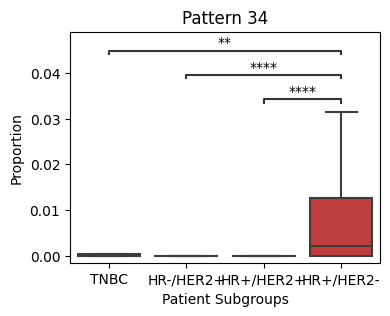

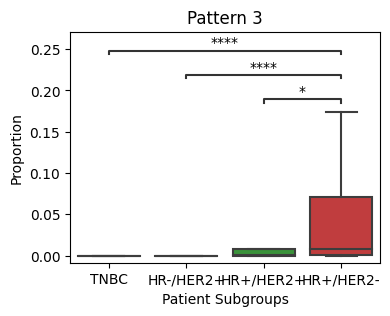

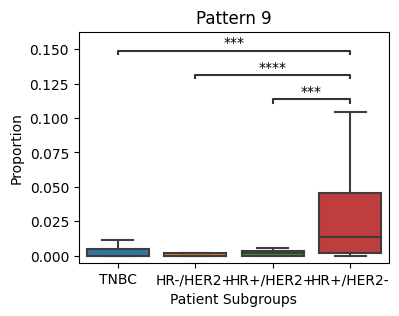

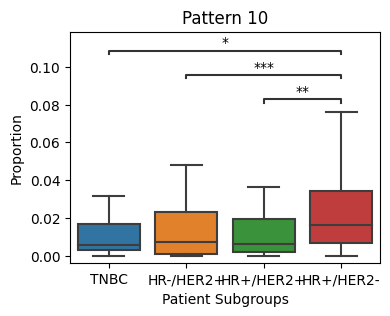

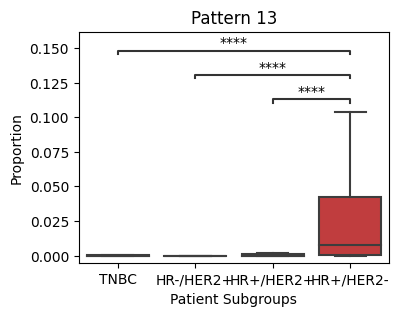

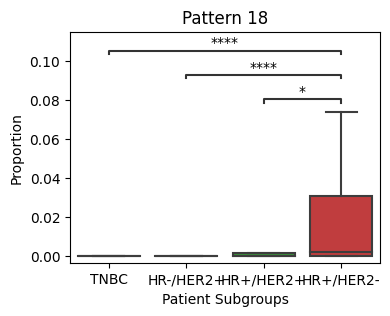

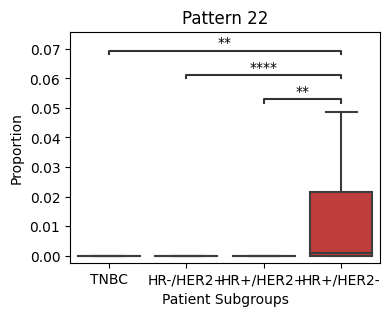

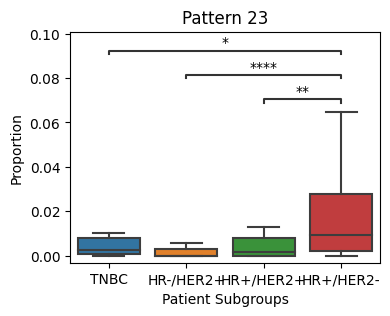

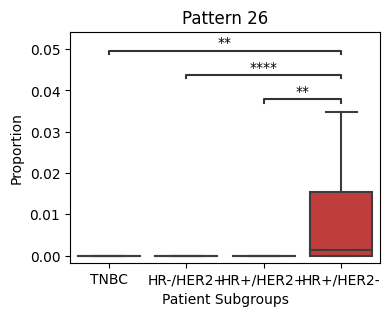

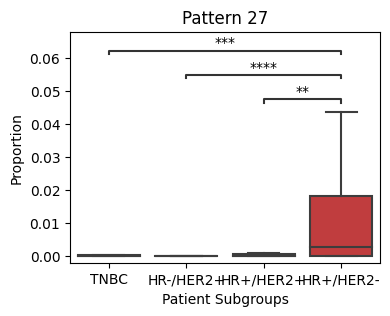

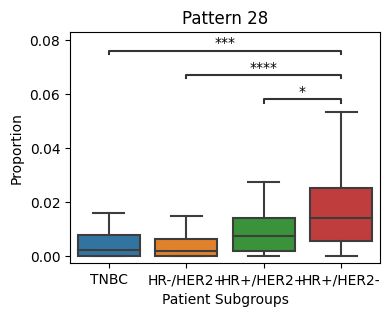

In [23]:
for subgroup_id, Candidates in Overpresented_patterns.items():
    print("Subgroup {}".format(subgroup_id))
    for pattern_id in Candidates:
        histogram = Histograms_[:, pattern_id] 
        DF_presentation = pd.DataFrame(
                {
                    "Proportion": histogram,
                    "Subgroup": ['S'+str(int(i)) for i in Subgroup_ids_],
                }
            )
        DF_presentation = DF_presentation.loc[DF_presentation["Subgroup"] != 0]
        f, ax = plt.subplots(figsize=(4, 3))
        sns.boxplot(
            x="Subgroup",
            y="Proportion",
            data=DF_presentation,
            showfliers=False,
            order=['S'+str(i) for i in range(1, len(HR)+1)],
        )
        from statannotations.Annotator import Annotator
        annot = Annotator(
            ax,
            [("S"+str(subgroup_id), "S"+str(i)) for i in range(1, len(HR)+1) if i != subgroup_id],
            data=DF_presentation,
            x="Subgroup",
            y="Proportion",
            order=['S'+str(i) for i in range(1, len(HR)+1)],
        )
        annot.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=2, )
        annot.apply_test()
        ax, test_results = annot.annotate()
        ax.set_title("Pattern {}".format(pattern_id+1))
        ax.set(ylabel = 'Proportion', xlabel = 'Patient Subgroups')
        ax.set_xticklabels(['TNBC', 'HR-/HER2+','HR+/HER2+','HR+/HER2-' ])


#### Signature map

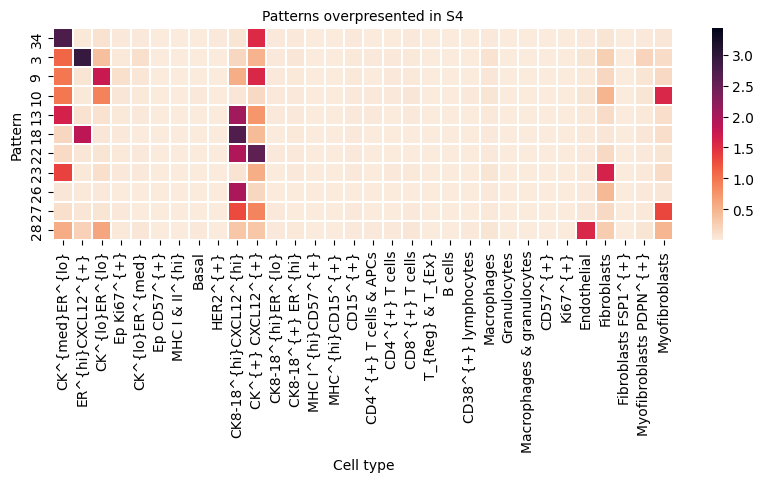

In [37]:
from b_Soft_WL_Kernel.SoftWL import compute_cluster_centroids
from definitions import get_node_id
from utils import reverse_dict

# Retrive cluster data
FILE_NAMES = os.listdir(
    os.path.join(PROJECT_ROOT, "Output", "b_Soft_WL_Kernel_random_split", "Danenberg", "Subset_1", 'Subtrees')
)
X = []
Cluster_identities = []
Indices = []
for i in range(len(FILE_NAMES)):
    file_name = FILE_NAMES[i]
    x = np.load(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "Subtrees",
            file_name,
            "neighborhood_aggregation",
            node_label,
            "X" + str(iteration) + ".npy",
        )
    )
    cluster_identities = np.load(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_1",
            "Subtrees",
            file_name,
            "pattern_ids",
            node_label,
            "pattern_id_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + ".npy",
        )
    )
    indices = np.zeros(x.shape[0], dtype=int)
    indices[:] = i
    Indices.append(indices)
    X.append(x)
    Cluster_identities.append(cluster_identities)
X = np.concatenate(X, axis=0)
Cluster_identities = np.concatenate(Cluster_identities, axis=0)
Indices = np.concatenate(Indices, axis=0)
Centroids = compute_cluster_centroids(X, Cluster_identities)
Signature = Centroids.T
Cell_type_name_list = [reverse_dict(get_node_id("Danenberg", node_label))[i] for i in range(Centroids.shape[1])]

for subgroup_id, Candidates in Overpresented_patterns.items():
    if len(Candidates) == 0:
        continue
    f, ax= plt.subplots(1,1,figsize=(10,0.25*len(Candidates)))
    sns.heatmap(
            Signature[:, np.array(Candidates)].T,
            ax=ax,
            cbar=True,
            cmap="rocket_r",
            linewidth=0.005,
            # edgecolor="black",
            vmax=np.percentile(Signature, 99),
            vmin=np.percentile(Signature, 1),
        )
    ax.set_xticklabels(Cell_type_name_list, rotation=90, fontsize=10)
    ax.set_yticklabels([i+1 for i in np.array(Candidates)], fontsize=10)
    # ax.set_ylabel("TME pattern index", fontsize=10)
    ax.set(xlabel = 'Cell type', ylabel = 'Pattern')
    ax.set_title(f"Patterns overpresented in S{subgroup_id}", fontsize=10)
    plt.show()



#### Representative examples

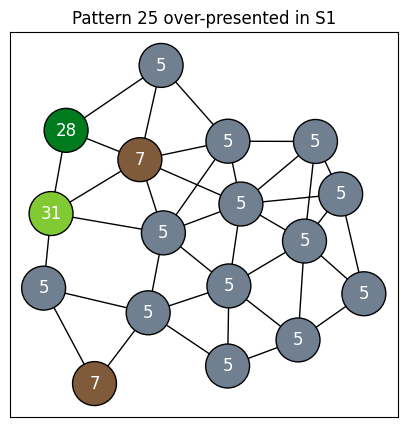

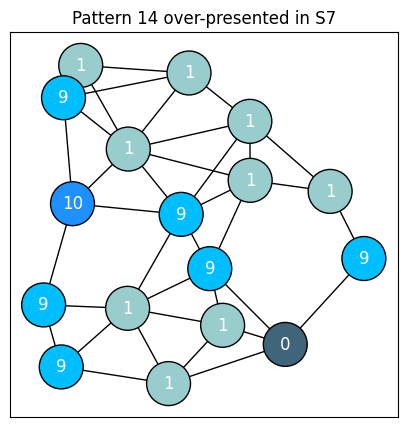

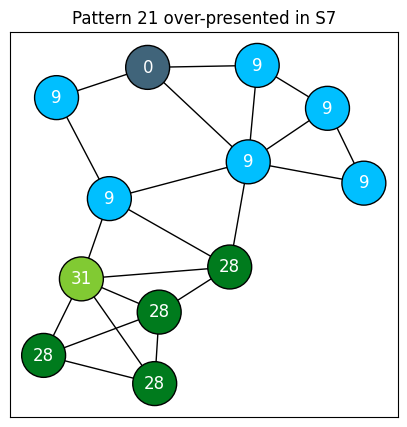

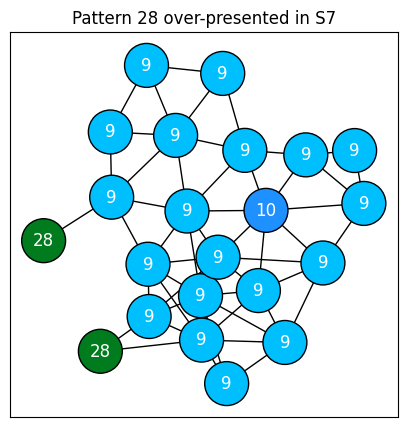

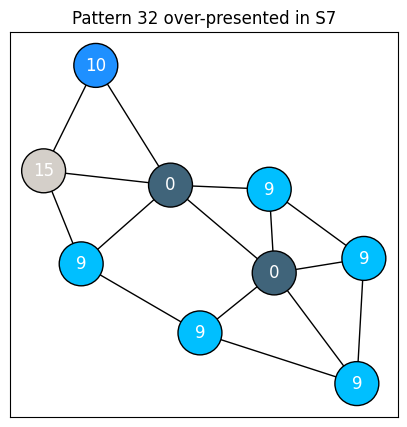

/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


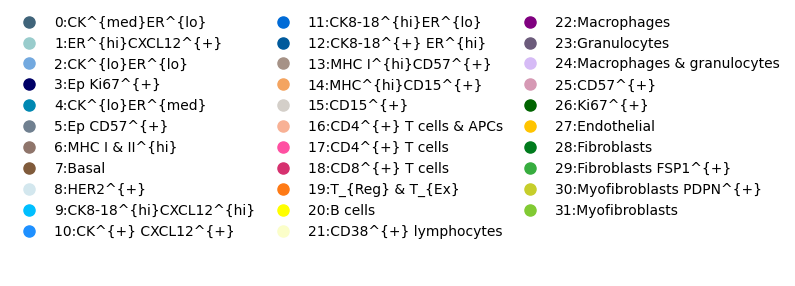

In [44]:
from definitions import get_node_id, get_node_color
from utils import reverse_dict
from overpresented_patterns import find_representative_examples, decide_subtree_boundary, construct_cellular_graph
def get_pos(G):
    x = nx.get_node_attributes(G, "X")
    y = nx.get_node_attributes(G, "Y")
    pos = {}
    for key, _ in x.items():
        pos[key] = (x[key], y[key])
    return pos
def normalize_pos(pos):
    x = np.array([pos[key][0] for key in pos.keys()])
    y = np.array([pos[key][1] for key in pos.keys()])
    x = x - np.mean(x)
    y = y - np.mean(y)
    pos_normalized = {}
    for i, key in enumerate(pos.keys()):
        pos_normalized[key] = (x[i], y[i])
    return pos_normalized

for subgroup_id, Candidates in Overpresented_patterns.items():
    for pattern_id in Candidates:
        Examples = find_representative_examples(pattern_id, Centroids, FILE_NAMES, X, Cluster_identities, Indices, num_examples = 1)
        for patient_id, image_id, subtree_root_idx in Examples:
            cells_ = pd.read_csv(
                    os.path.join(
                        PROJECT_ROOT,
                        "Input",
                        "Single-cell",
                        "Danenberg",
                        "patient_{}_image_{}.csv".format(patient_id, image_id),
                    )
                )
            Adj = np.load(
                    os.path.join(
                        PROJECT_ROOT,
                        "Output",
                        "a_Cellular_graph_random_split",
                        "Danenberg",
                        "Subset_1",
                        "patient_{}_image_{}".format(patient_id, image_id),
                        "Adj.npy",
                    )
                )
            cell_type_ids = np.load(
                    os.path.join(
                        PROJECT_ROOT,
                        "Output",
                        "a_Cellular_graph_random_split",
                        "Danenberg",
                        "Subset_1",
                        "patient_{}_image_{}".format(patient_id, image_id),
                        node_label+".npy",
                    )
                )
            subtree_leaf_indices = decide_subtree_boundary(subtree_root_idx, Adj, iteration, boundary_weight_threshold = 0.1)
            cell_types = [reverse_dict(get_node_id("Danenberg", node_label))[i] for i in cell_type_ids]
            cell_type_colors = [get_node_color("Danenberg", node_label)[i] for i in cell_types]
            cellular_graph = construct_cellular_graph(Adj, cells_, cell_types, cell_type_ids, cell_type_colors, edges_visible=0.05)
            subtree_graph = nx.subgraph(cellular_graph, subtree_leaf_indices)
            f, ax = plt.subplots(figsize=(5,5))
            nx.draw_networkx(
                    subtree_graph,
                    normalize_pos(get_pos(subtree_graph)),
                    node_size=1000,
                    node_color= [value for key, value in nx.get_node_attributes(subtree_graph, "cell_type_color").items()],
                    labels = nx.get_node_attributes(subtree_graph, "cell_type_id"),
                    font_color = 'white',
                    with_labels = True,
                    edgecolors="black",
                    ax=ax,
                )
            ax.set_title("Pattern {} over-presented in S{}".format(pattern_id+1, subgroup_id))
# Print Legend
fig, ax = plt.subplots(figsize=(10, 0.4), tight_layout=True)
func = lambda m, c: plt.plot([], [], marker=m, color=c, ls="none", markersize=8)[0]
cell_types = [str(i)+":"+reverse_dict(get_node_id("Danenberg", node_label))[i] for i in range(len(get_node_id("Danenberg", node_label)))]
handles = [func("o", get_node_color("Danenberg", node_label)[i.split(':')[1]]) for i in cell_types]
ax.legend(
        handles,
        cell_types,
        loc=3,
        framealpha=0,
        frameon=1,
        ncols=3,
        bbox_to_anchor=(0, 1.02, 1, 0.2),
        mode="expand",
        borderaxespad=0.0,
        fontsize=10,
    )
ax.axis("off")
plt.show()

## Merge patterns into some large categories

In [29]:
Overpresented_patterns_ = {
    'Overpresented in HR+/HER2-': Overpresented_patterns[4],

}

## Test over-presented patterns

Pattern 1: hr = 0.7915242830079438, p = 0.01451505816591256


/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)
/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


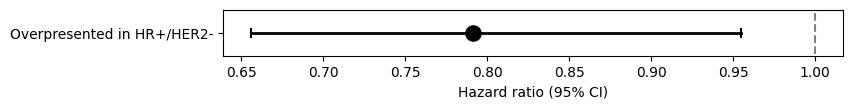

In [30]:
test_metric = 'proportion'
DF = pd.DataFrame({
    'length': Length_,
    'status': Status_,
})
Num_patterns_to_test = 0
for subgroup_id, Candidates in Overpresented_patterns_.items():
    Num_patterns_to_test += 1

f, ax = plt.subplots(Num_patterns_to_test, 1, figsize=(8, 0.6*Num_patterns_to_test), sharex= True, tight_layout=True)
pattern_id = 0
i = 0
for name, Candidates in Overpresented_patterns_.items():
    yticklabels =[name]
    histogram = Histograms_[:, np.array(Candidates)].mean(axis=1)
    if test_metric == 'proportion':
        DF["pattern_"+str(pattern_id+1)] = (histogram - np.mean(histogram))/np.std(histogram)
    elif test_metric == 'existence':
        DF["pattern_"+str(pattern_id+1)] = histogram > 0.001
    cph = CoxPHFitter()
    cph.fit(DF, duration_col='length', event_col='status', formula="pattern_"+str(pattern_id+1))
    hr = cph.hazard_ratios_["pattern_"+str(pattern_id+1)]
    hr_lb = np.exp(cph.confidence_intervals_["95% lower-bound"]["pattern_"+str(pattern_id+1)])
    hr_ub = np.exp(cph.confidence_intervals_["95% upper-bound"]["pattern_"+str(pattern_id+1)])
    p = cph.summary["p"]["pattern_"+str(pattern_id+1)]
    print("Pattern {}: hr = {}, p = {}".format(pattern_id+1, hr, p))
    if p < 0.05/Num_patterns_to_test:
        color = 'k'
    else:
        color = 'grey'
        
    if Num_patterns_to_test == 1:
        ax.plot([hr_lb, hr_ub], [0, 0], color = color, linewidth=2)
        ax.scatter([hr], [0], color = color, s=120)
        ax.scatter([hr_lb], [0], s=60,color = color,  marker="|")
        ax.scatter([hr_ub],[0],   s=60, color = color, marker="|")
        ax.set_yticks([0])
        ax.set_yticklabels(yticklabels)
        ax.get_yticklabels()[0].set_color(color)
        ax.vlines(1, -1, 1, color="grey", linestyle="--")
    else:
        ax[i].plot([hr_lb, hr_ub], [0, 0], color = color, linewidth=2)
        ax[i].scatter([hr], [0], color = color, s=120)
        ax[i].scatter([hr_lb], [0], s=60,color = color,  marker="|")
        ax[i].scatter([hr_ub],[0],   s=60, color = color, marker="|")
        ax[i].set_yticks([0])
        ax[i].set_yticklabels(yticklabels)
        ax[i].get_yticklabels()[0].set_color(color)
        ax[i].vlines(1, -1, 1, color="grey", linestyle="--")
    i+=1
    pattern_id+=1


if Num_patterns_to_test == 1:
    ax.set_xlabel("Hazard ratio (95% CI)")
else:
    ax[i-1].set_xlabel("Hazard ratio (95% CI)")


#### Each individual patterns

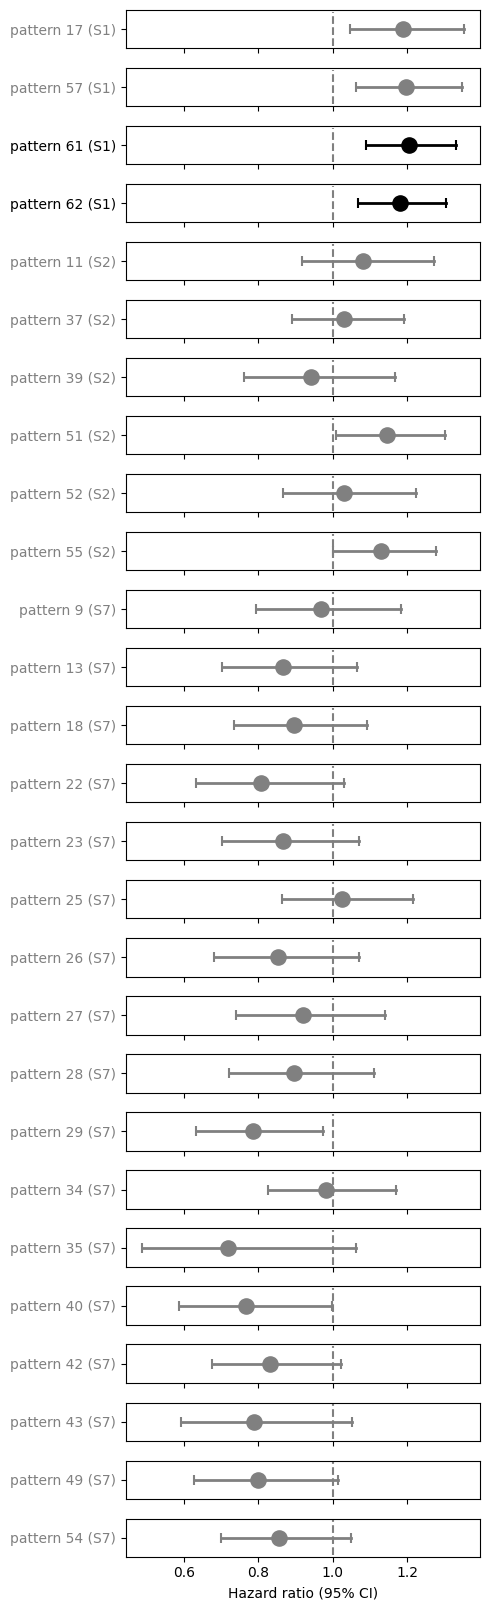

In [25]:
test_metric = 'proportion'
DF = pd.DataFrame({
    'length': Length_,
    'status': Status_,
})
Num_patterns_to_test = 0
for subgroup_id, Candidates in Overpresented_patterns.items():
    Num_patterns_to_test += len(Candidates)

f, ax = plt.subplots(Num_patterns_to_test, 1, figsize=(5, 0.6*Num_patterns_to_test), sharex= True, tight_layout=True)
i = 0
for subgroup_id, Candidates in Overpresented_patterns.items():
    for pattern_id in Candidates:
        yticklabels =['pattern {} (S{})'.format(str(pattern_id+1), subgroup_id )]
        histogram = Histograms_[:, pattern_id]
        if test_metric == 'proportion':
            DF["pattern_"+str(pattern_id+1)] = (histogram - np.mean(histogram))/np.std(histogram)
        elif test_metric == 'existence':
            DF["pattern_"+str(pattern_id+1)] = histogram > 0
        cph = CoxPHFitter()
        cph.fit(DF, duration_col='length', event_col='status', formula="pattern_"+str(pattern_id+1))
        hr = cph.hazard_ratios_["pattern_"+str(pattern_id+1)]
        hr_lb = np.exp(cph.confidence_intervals_["95% lower-bound"]["pattern_"+str(pattern_id+1)])
        hr_ub = np.exp(cph.confidence_intervals_["95% upper-bound"]["pattern_"+str(pattern_id+1)])
        p = cph.summary["p"]["pattern_"+str(pattern_id+1)]

        if p < 0.05/Num_patterns_to_test:
            color = 'k'
        else:
            color = 'grey'
        
        if Num_patterns_to_test == 1:
            ax.plot([hr_lb, hr_ub], [0, 0], color = color, linewidth=2)
            ax.scatter([hr], [0], color = color, s=120)
            ax.scatter([hr_lb], [0], s=60,color = color,  marker="|")
            ax.scatter([hr_ub],[0],   s=60, color = color, marker="|")
            ax.set_yticks([0])
            ax.set_yticklabels(yticklabels)
            ax.get_yticklabels()[0].set_color(color)
            ax.vlines(1, -1, 1, color="grey", linestyle="--")
        else:
            ax[i].plot([hr_lb, hr_ub], [0, 0], color = color, linewidth=2)
            ax[i].scatter([hr], [0], color = color, s=120)
            ax[i].scatter([hr_lb], [0], s=60,color = color,  marker="|")
            ax[i].scatter([hr_ub],[0],   s=60, color = color, marker="|")
            ax[i].set_yticks([0])
            ax[i].set_yticklabels(yticklabels)
            ax[i].get_yticklabels()[0].set_color(color)
            ax[i].vlines(1, -1, 1, color="grey", linestyle="--")
        i+=1

if Num_patterns_to_test == 1:
    ax.set_xlabel("Hazard ratio (95% CI)")
else:
    ax[i-1].set_xlabel("Hazard ratio (95% CI)")


# Validation

## Subset 2

In [31]:
SoftWL_dict_cohort2 = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Danenberg",
            "Subset_2",
            "Matched_SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_"
            + node_label
            + "_centroid_alignment.pkl",
        ),
        "rb",
    ),
)
Patient_IDs_cohort2 = SoftWL_dict_cohort2["Patient_id"]
Histograms_cohort2 = SoftWL_dict_cohort2["Histogram"]
Histograms_cohort2 = Histograms_cohort2/np.sum(Histograms_cohort2, axis=1, keepdims=True)

Patient_Inclusion_mask_cohort2 = np.ones(len(Patient_IDs_cohort2), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs_cohort2]
    patient_inclusion_mask_cohort2 = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask_cohort2 = Patient_Inclusion_mask_cohort2 * patient_inclusion_mask_cohort2
Patient_IDs_cohort2 = np.array(Patient_IDs_cohort2)[Patient_Inclusion_mask_cohort2]
Histograms_cohort2 = Histograms_cohort2[Patient_Inclusion_mask_cohort2, :]
print("{} patients are included".format(len(Patient_IDs_cohort2)))

Length_cohort2 = [clinical.loc[clinical['patient_id'] == i, survival_type+' Survival (Months)'].values[0] for i in Patient_IDs_cohort2]
Status_cohort2 = [clinical.loc[clinical['patient_id'] == i, survival_type+' Survival Status'].values[0] for i in Patient_IDs_cohort2]  
DF_cohort2 = pd.DataFrame({"Length": Length_cohort2, "Status": Status_cohort2}).dropna()
Length_cohort2_ = np.array(DF_cohort2["Length"])
Status_cohort2_ = np.array(DF_cohort2["Status"])
Histograms_cohort2_ = Histograms_cohort2[DF_cohort2.index.values, :]
Patient_IDs_cohort2_ = np.array(Patient_IDs_cohort2)[DF_cohort2.index.values]

200 patients are included


Overpresented in HR+/HER2- 0.7592567832608442 0.06912619017981443


/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)
/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


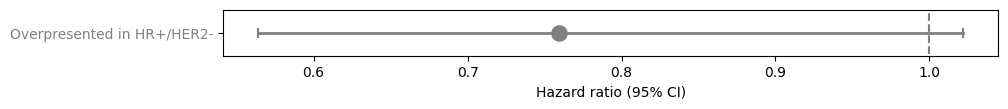

In [32]:
test_metric = 'proportion'
DF = pd.DataFrame({
    'length': Length_cohort2_,
    'status': Status_cohort2_,
})
Num_patterns_to_test = 0
for subgroup_id, Candidates in Overpresented_patterns_.items():
    Num_patterns_to_test += 1

f, ax = plt.subplots(Num_patterns_to_test, 1, figsize=(10, 0.6*Num_patterns_to_test), sharex= True, tight_layout=True)
i = 0
for name, Candidates in Overpresented_patterns_.items():
    yticklabels =[name]
    pattern_id = i
    histogram = Histograms_cohort2_[:, np.array(Candidates)].sum(axis=1)
    if test_metric == 'proportion':
        DF["pattern_"+str(pattern_id+1)] = (histogram - np.mean(histogram))/np.std(histogram)
    elif test_metric == 'existence':
        DF["pattern_"+str(pattern_id+1)] = histogram > 0
    cph = CoxPHFitter()
    cph.fit(DF, duration_col='length', event_col='status', formula="pattern_"+str(pattern_id+1))
    hr = cph.hazard_ratios_["pattern_"+str(pattern_id+1)]
    hr_lb = np.exp(cph.confidence_intervals_["95% lower-bound"]["pattern_"+str(pattern_id+1)])
    hr_ub = np.exp(cph.confidence_intervals_["95% upper-bound"]["pattern_"+str(pattern_id+1)])
    p = cph.summary["p"]["pattern_"+str(pattern_id+1)]
    print(name, hr, p)

    if p < 0.05/Num_patterns_to_test:
        color = 'k'
    else:
        color = 'grey'
        
    if Num_patterns_to_test == 1:
        ax.plot([hr_lb, hr_ub], [0, 0], color = color, linewidth=2)
        ax.scatter([hr], [0], color = color, s=120)
        ax.scatter([hr_lb], [0], s=60,color = color,  marker="|")
        ax.scatter([hr_ub],[0],   s=60, color = color, marker="|")
        ax.set_yticks([0])
        ax.set_yticklabels(yticklabels)
        ax.get_yticklabels()[0].set_color(color)
        ax.vlines(1, -1, 1, color="grey", linestyle="--")
    else:
        ax[i].plot([hr_lb, hr_ub], [0, 0], color = color, linewidth=2)
        ax[i].scatter([hr], [0], color = color, s=120)
        ax[i].scatter([hr_lb], [0], s=60,color = color,  marker="|")
        ax[i].scatter([hr_ub],[0],   s=60, color = color, marker="|")
        ax[i].set_yticks([0])
        ax[i].set_yticklabels(yticklabels)
        ax[i].get_yticklabels()[0].set_color(color)
        ax[i].vlines(1, -1, 1, color="grey", linestyle="--")
    i+=1

if Num_patterns_to_test == 1:
    ax.set_xlabel("Hazard ratio (95% CI)")
else:
    ax[i-1].set_xlabel("Hazard ratio (95% CI)")


#### Each individual patterns

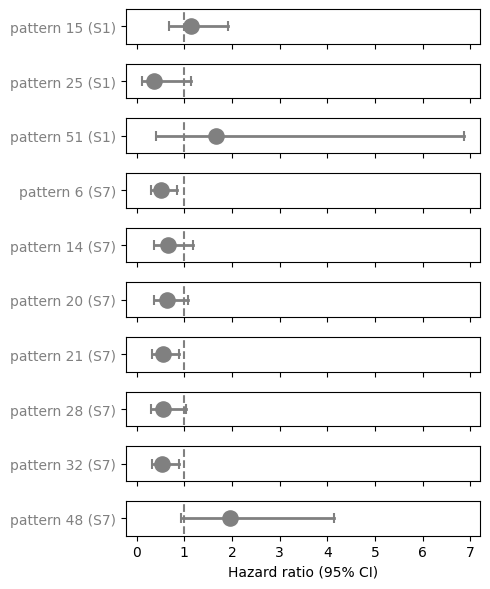

In [14]:
test_metric = 'existence'
Histograms_cohort2_ = Histograms_cohort2_/np.sum(Histograms_cohort2_, axis=1, keepdims=True)
DF = pd.DataFrame({
    'length': Length_cohort2_,
    'status': Status_cohort2_,
})
Num_patterns_to_test = 0
for subgroup_id, Candidates in Overpresented_patterns.items():
    Num_patterns_to_test += len(Candidates)

f, ax = plt.subplots(Num_patterns_to_test, 1, figsize=(5, 0.6*Num_patterns_to_test), sharex= True, tight_layout=True)
i = 0
for subgroup_id, Candidates in Overpresented_patterns.items():
    for pattern_id in Candidates:
        yticklabels =['pattern {} (S{})'.format(str(pattern_id+1), subgroup_id )]
        histogram = Histograms_cohort2_[:, pattern_id]
        if test_metric == 'proportion':
            DF["pattern_"+str(pattern_id+1)] = (histogram - np.mean(histogram))/np.std(histogram)
        elif test_metric == 'existence':
            DF["pattern_"+str(pattern_id+1)] = histogram > 0
        cph = CoxPHFitter()
        cph.fit(DF, duration_col='length', event_col='status', formula="pattern_"+str(pattern_id+1))
        hr = cph.hazard_ratios_["pattern_"+str(pattern_id+1)]
        hr_lb = np.exp(cph.confidence_intervals_["95% lower-bound"]["pattern_"+str(pattern_id+1)])
        hr_ub = np.exp(cph.confidence_intervals_["95% upper-bound"]["pattern_"+str(pattern_id+1)])
        p = cph.summary["p"]["pattern_"+str(pattern_id+1)]

        if p < 0.05/Num_patterns_to_test:
            color = 'k'
        else:
            color = 'grey'
        
        if Num_patterns_to_test == 1:
            ax.plot([hr_lb, hr_ub], [0, 0], color = color, linewidth=2)
            ax.scatter([hr], [0], color = color, s=120)
            ax.scatter([hr_lb], [0], s=60,color = color,  marker="|")
            ax.scatter([hr_ub],[0],   s=60, color = color, marker="|")
            ax.set_yticks([0])
            ax.set_yticklabels(yticklabels)
            ax.get_yticklabels()[0].set_color(color)
            ax.vlines(1, -1, 1, color="grey", linestyle="--")
        else:
            ax[i].plot([hr_lb, hr_ub], [0, 0], color = color, linewidth=2)
            ax[i].scatter([hr], [0], color = color, s=120)
            ax[i].scatter([hr_lb], [0], s=60,color = color,  marker="|")
            ax[i].scatter([hr_ub],[0],   s=60, color = color, marker="|")
            ax[i].set_yticks([0])
            ax[i].set_yticklabels(yticklabels)
            ax[i].get_yticklabels()[0].set_color(color)
            ax[i].vlines(1, -1, 1, color="grey", linestyle="--")
        i+=1

if Num_patterns_to_test == 1:
    ax.set_xlabel("Hazard ratio (95% CI)")
else:
    ax[i-1].set_xlabel("Hazard ratio (95% CI)")


## Jackson

In [33]:
from utils import process_Jackson_clinical_data
survival_type_jackson = "Overall"
SoftWL_dict_jackson = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel_random_split",
            "Jackson",
            "Matched_SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_"
            + node_label
            + "_centroid_alignment.pkl",
        ),
        "rb",
    ),
)
Patient_IDs_jackson = SoftWL_dict_jackson["Patient_id"]
Histograms_jackson = SoftWL_dict_jackson["Histogram"]
Histograms_jackson = Histograms_jackson/np.sum(Histograms_jackson, axis=1, keepdims=True)
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Jackson",
        "clinical.csv",
    )
)
clinical = process_Jackson_clinical_data(clinical)

Patient_Inclusion_mask_jackson = np.ones(len(Patient_IDs_jackson), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs_jackson]
    patient_inclusion_mask_jackson = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask_jackson = Patient_Inclusion_mask_jackson * patient_inclusion_mask_jackson
Patient_IDs_jackson = np.array(Patient_IDs_jackson)[Patient_Inclusion_mask_jackson]
Histograms_jackson = Histograms_jackson[Patient_Inclusion_mask_jackson, :]

Length_jackson = [
        clinical.loc[clinical["patient_id"] == i, survival_type_jackson+" Survival (Months)"].values[0]
        for i in Patient_IDs_jackson
    ]
Status_jackson = [
        clinical.loc[clinical["patient_id"] == i, survival_type_jackson+" Survival Status"].values[0]
        for i in Patient_IDs_jackson
    ]

DF_jackson = pd.DataFrame({"Length": Length_jackson, "Status": Status_jackson}).dropna()
Length_jackson_ = np.array(DF_jackson["Length"])
Status_jackson_ = np.array(DF_jackson["Status"])
Histograms_jackson_ = Histograms_jackson[DF_jackson.index.values, :]
Patient_IDs_jackson_ = np.array(Patient_IDs_jackson)[DF_jackson.index.values]


Overpresented in HR+/HER2- 0.7542037226484083 0.05868855595090692


/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)
/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


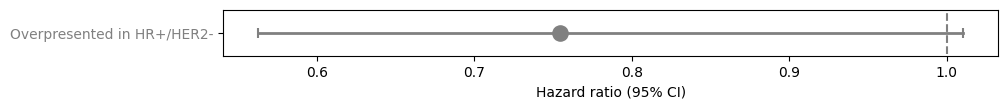

In [34]:
test_metric = 'proportion'
DF = pd.DataFrame({
    'length': Length_jackson_,
    'status': Status_jackson_,
})
Num_patterns_to_test = 0
for subgroup_id, Candidates in Overpresented_patterns_.items():
    Num_patterns_to_test += 1

f, ax = plt.subplots(Num_patterns_to_test, 1, figsize=(10, 0.6*Num_patterns_to_test), sharex= True, tight_layout=True)
i = 0
for name, Candidates in Overpresented_patterns_.items():
    yticklabels =[name]
    pattern_id = i
    histogram = Histograms_jackson_[:, np.array(Candidates)].sum(axis=1)
    if test_metric == 'proportion':
        DF["pattern_"+str(pattern_id+1)] = (histogram - np.mean(histogram))/np.std(histogram)
    elif test_metric == 'existence':
        DF["pattern_"+str(pattern_id+1)] = histogram > 0
    cph = CoxPHFitter()
    cph.fit(DF, duration_col='length', event_col='status', formula="pattern_"+str(pattern_id+1))
    hr = cph.hazard_ratios_["pattern_"+str(pattern_id+1)]
    hr_lb = np.exp(cph.confidence_intervals_["95% lower-bound"]["pattern_"+str(pattern_id+1)])
    hr_ub = np.exp(cph.confidence_intervals_["95% upper-bound"]["pattern_"+str(pattern_id+1)])
    p = cph.summary["p"]["pattern_"+str(pattern_id+1)]
    print(name, hr, p)

    if p < 0.05/Num_patterns_to_test:
        color = 'k'
    else:
        color = 'grey'
        
    if Num_patterns_to_test == 1:
        ax.plot([hr_lb, hr_ub], [0, 0], color = color, linewidth=2)
        ax.scatter([hr], [0], color = color, s=120)
        ax.scatter([hr_lb], [0], s=60,color = color,  marker="|")
        ax.scatter([hr_ub],[0],   s=60, color = color, marker="|")
        ax.set_yticks([0])
        ax.set_yticklabels(yticklabels)
        ax.get_yticklabels()[0].set_color(color)
        ax.vlines(1, -1, 1, color="grey", linestyle="--")
    else:
        ax[i].plot([hr_lb, hr_ub], [0, 0], color = color, linewidth=2)
        ax[i].scatter([hr], [0], color = color, s=120)
        ax[i].scatter([hr_lb], [0], s=60,color = color,  marker="|")
        ax[i].scatter([hr_ub],[0],   s=60, color = color, marker="|")
        ax[i].set_yticks([0])
        ax[i].set_yticklabels(yticklabels)
        ax[i].get_yticklabels()[0].set_color(color)
        ax[i].vlines(1, -1, 1, color="grey", linestyle="--")
    i+=1

if Num_patterns_to_test == 1:
    ax.set_xlabel("Hazard ratio (95% CI)")
else:
    ax[i-1].set_xlabel("Hazard ratio (95% CI)")


### Each individual patterns

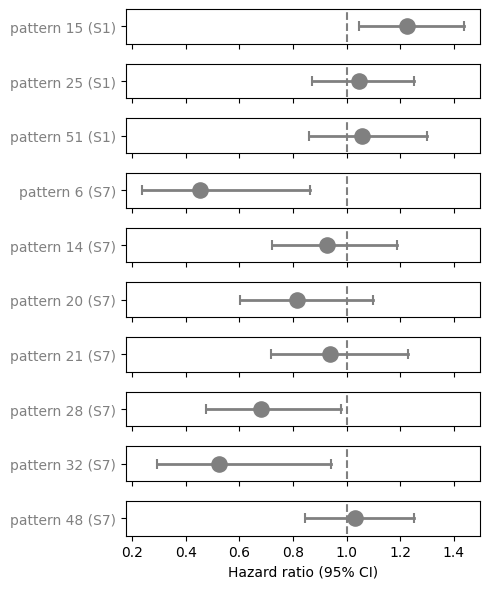

In [16]:
test_metric = 'proportion'
Histograms_cohort2_ = Histograms_cohort2_/np.sum(Histograms_cohort2_, axis=1, keepdims=True)
DF = pd.DataFrame({
    'length': Length_jackson_,
    'status': Status_jackson_,
})
Num_patterns_to_test = 0
for subgroup_id, Candidates in Overpresented_patterns.items():
    Num_patterns_to_test += len(Candidates)

f, ax = plt.subplots(Num_patterns_to_test, 1, figsize=(5, 0.6*Num_patterns_to_test), sharex= True, tight_layout=True)
i = 0
for subgroup_id, Candidates in Overpresented_patterns.items():
    for pattern_id in Candidates:
        yticklabels =['pattern {} (S{})'.format(str(pattern_id+1), subgroup_id )]
        histogram = Histograms_jackson_[:, pattern_id]
        if test_metric == 'proportion':
            DF["pattern_"+str(pattern_id+1)] = (histogram - np.mean(histogram))/np.std(histogram)
        elif test_metric == 'existence':
            DF["pattern_"+str(pattern_id+1)] = histogram > 0
        cph = CoxPHFitter()
        cph.fit(DF, duration_col='length', event_col='status', formula="pattern_"+str(pattern_id+1))
        hr = cph.hazard_ratios_["pattern_"+str(pattern_id+1)]
        hr_lb = np.exp(cph.confidence_intervals_["95% lower-bound"]["pattern_"+str(pattern_id+1)])
        hr_ub = np.exp(cph.confidence_intervals_["95% upper-bound"]["pattern_"+str(pattern_id+1)])
        p = cph.summary["p"]["pattern_"+str(pattern_id+1)]

        if p < 0.05/Num_patterns_to_test:
            color = 'k'
        else:
            color = 'grey'
        
        if Num_patterns_to_test == 1:
            ax.plot([hr_lb, hr_ub], [0, 0], color = color, linewidth=2)
            ax.scatter([hr], [0], color = color, s=120)
            ax.scatter([hr_lb], [0], s=60,color = color,  marker="|")
            ax.scatter([hr_ub],[0],   s=60, color = color, marker="|")
            ax.set_yticks([0])
            ax.set_yticklabels(yticklabels)
            ax.get_yticklabels()[0].set_color(color)
            ax.vlines(1, -1, 1, color="grey", linestyle="--")
        else:
            ax[i].plot([hr_lb, hr_ub], [0, 0], color = color, linewidth=2)
            ax[i].scatter([hr], [0], color = color, s=120)
            ax[i].scatter([hr_lb], [0], s=60,color = color,  marker="|")
            ax[i].scatter([hr_ub],[0],   s=60, color = color, marker="|")
            ax[i].set_yticks([0])
            ax[i].set_yticklabels(yticklabels)
            ax[i].get_yticklabels()[0].set_color(color)
            ax[i].vlines(1, -1, 1, color="grey", linestyle="--")
        i+=1

if Num_patterns_to_test == 1:
    ax.set_xlabel("Hazard ratio (95% CI)")
else:
    ax[i-1].set_xlabel("Hazard ratio (95% CI)")


# K-M Plot

0.02112908501810959
Pattern = 15, p-value = 0.9581985
0.11891426771551486
Pattern = 28, p-value = 0.0189348
0.08094796431779594
Pattern = 21, p-value = 0.0658578
0.028093867097644703
Pattern = 6, p-value = 0.0078015
0.006412399675315339
Pattern = 32, p-value = 0.0170867


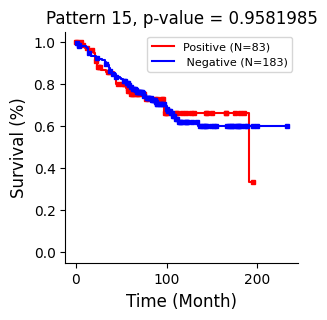

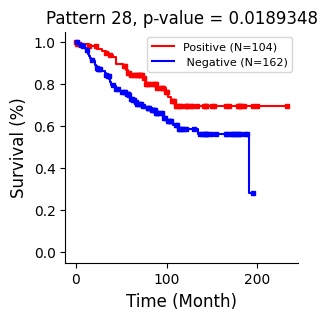

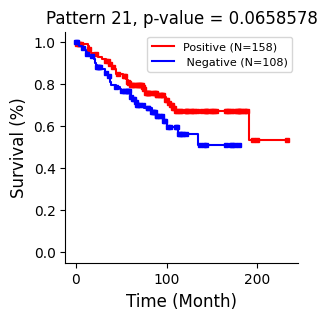

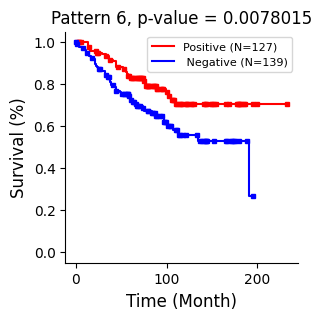

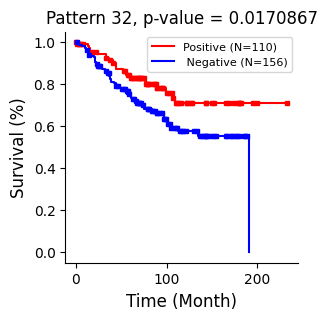

In [451]:

kmf = KaplanMeierFitter()
for subgroup_id, Candidates in Overpresented_patterns.items():
    for pattern_id in Candidates:
        histogram_pattern = Histograms_jackson_[:, pattern_id]
        print(np.percentile(histogram_pattern, 90))
        threshold = 0
        length_A, event_observed_A = (
                Length_jackson_[histogram_pattern > threshold],
                Status_jackson_[histogram_pattern > threshold],
            )
        length_B, event_observed_B = (
                Length_jackson_[histogram_pattern <= threshold],
                Status_jackson_[histogram_pattern <= threshold],
            )
        log_rank_test = multivariate_logrank_test(
                np.concatenate([length_A, length_B]),
                [0] * len(length_A) + [1] * len(length_B),
                np.concatenate([event_observed_A, event_observed_B]),
            )
        p_value = log_rank_test.p_value
        print("Pattern = {}, p-value = {:.7f}".format(pattern_id+1, p_value))
        f, ax = plt.subplots(figsize=(3, 3))
        kmf.fit(
                    length_A, event_observed_A, label="Positive (N={})".format(len(length_A))
                )
        kmf.plot_survival_function(
                    ax=ax,
                    ci_show=False,
                    color="red",
                    show_censors=True,
                    censor_styles={"ms": 3, "marker": "s"},
                )

        kmf.fit(
                    length_B, event_observed_B, label=" Negative (N={})".format(len(length_B))
                )
        kmf.plot_survival_function(
                    ax=ax,
                    ci_show=False,
                    color='blue',
                    show_censors=True,
                    censor_styles={"ms": 3, "marker": "s"},
                )
        ax.legend(ncol=1, fontsize=8)
        ax.set_title(
                    "Pattern {}, p-value = {:.7f}".format(pattern_id+1, p_value), fontsize=12
                )
        ax.set_xlabel("Time (Month)", fontsize=12)
        ax.set_ylabel("Survival (%)", fontsize=12)
        ax.set(
                    ylim=(-0.05, 1.05),
                )
        sns.despine()
        

#### Individual Test

Pattern = 28, p-value = 0.0607985
Pattern = 21, p-value = 0.0137315
Pattern = 6, p-value = 0.0086463
Pattern = 32, p-value = 0.0130761


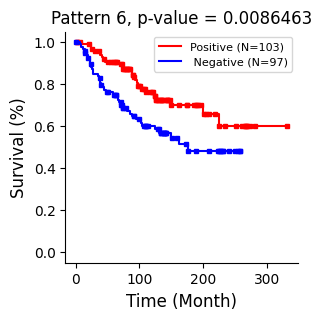

In [450]:
kmf = KaplanMeierFitter()
for pattern_id in Candidates:
    histogram_pattern = Histograms_cohort2_[:, pattern_id]
    if 1:
        threshold = 0
        length_A, event_observed_A = (
            Length_cohort2_[histogram_pattern > threshold],
            Status_cohort2_[histogram_pattern > threshold],
        )
        length_B, event_observed_B = (
            Length_cohort2_[histogram_pattern <= threshold],
            Status_cohort2_[histogram_pattern <= threshold],
        )
        log_rank_test = multivariate_logrank_test(
            np.concatenate([length_A, length_B]),
            [0] * len(length_A) + [1] * len(length_B),
            np.concatenate([event_observed_A, event_observed_B]),
        )
        p_value = log_rank_test.p_value
        print("Pattern = {}, p-value = {:.7f}".format(pattern_id+1, p_value))
        if p_value < 0.05/len(Candidates):
            f, ax = plt.subplots(figsize=(3, 3))
            kmf.fit(
                length_A, event_observed_A, label="Positive (N={})".format(len(length_A))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color="red",
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )

            kmf.fit(
                length_B, event_observed_B, label=" Negative (N={})".format(len(length_B))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color='blue',
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )
            ax.legend(ncol=1, fontsize=8)
            ax.set_title(
                "Pattern {}, p-value = {:.7f}".format(pattern_id+1, p_value), fontsize=12
            )
            ax.set_xlabel("Time (Month)", fontsize=12)
            ax.set_ylabel("Survival (%)", fontsize=12)
            ax.set(
                ylim=(-0.05, 1.05),
            )
            sns.despine()
    else:
        threshold = np.percentile(histogram_pattern[histogram_pattern>0], 50)
        length_A, event_observed_A = (
            Length_cohort2_[histogram_pattern > threshold],
            Status_cohort2_[histogram_pattern > threshold],
        )
        length_B, event_observed_B = (
            Length_cohort2_[histogram_pattern == 0],
            Status_cohort2_[histogram_pattern == 0],
        )
        length_C, event_observed_C = (
            Length_cohort2_[
                (histogram_pattern > 0)
                & (histogram_pattern <= threshold)
            ],
            Status_cohort2_[
                (histogram_pattern > 0)
                & (histogram_pattern <= threshold)
            ],
        )
        log_rank_test = multivariate_logrank_test(
            np.concatenate([length_A, length_B, length_C]),
            [0] * len(length_A) + [1] * len(length_B) + [2] * len(length_C),
            np.concatenate([event_observed_A, event_observed_B, event_observed_C]),
        )
        p_value = log_rank_test.p_value
        print("Pattern = {}, p-value = {:.7f}".format(pattern_id+1, p_value))
        if p_value:
            f, ax = plt.subplots(figsize=(3, 3))
            kmf.fit(
                length_A, event_observed_A, label="High (N={})".format(len(length_A))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color="red",
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )
            kmf.fit(
                length_C, event_observed_C, label="Low (N={})".format(len(length_C))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color="orange",
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )

            kmf.fit(
                length_B, event_observed_B, label=" Negative (N={})".format(len(length_B))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color='blue',
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )
            ax.legend(ncol=1, fontsize=8)
            ax.set_title(
                "Pattern {}, p-value = {:.7f}".format(pattern_id+1, p_value), fontsize=12
            )
            ax.set_xlabel("Time (Month)", fontsize=12)
            ax.set_ylabel("Survival (%)", fontsize=12)
            ax.set(
                ylim=(-0.05, 1.05),
            )
            sns.despine()

# Other (probably) useful information

### KM-Plots

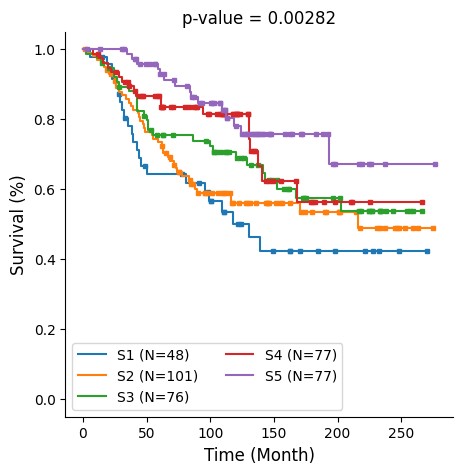

In [220]:
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5, 5))
for i, hr_dict in enumerate(HR):
    subgroup_id = hr_dict['subgroup_id']
    length_A, event_observed_A = (
            Length_[Subgroup_ids_ == subgroup_id],
            Status_[Subgroup_ids_ == subgroup_id],
        )
    label = "S{} (N={})".format(hr_dict["subgroup_id"], np.sum(Subgroup_ids_ == subgroup_id))
    kmf.fit(length_A, event_observed_A, label=label)
    kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[i],
    show_censors=True,
            censor_styles={"ms": 3, "marker": "s"})
log_rank_test  = multivariate_logrank_test(
        Length_[Subgroup_ids_!=0], Subgroup_ids_[Subgroup_ids_!=0],Status_[Subgroup_ids_!=0]
    )
p_value = log_rank_test.p_value
ax.legend(ncol=2, fontsize = 10)
ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()

### Population Graph

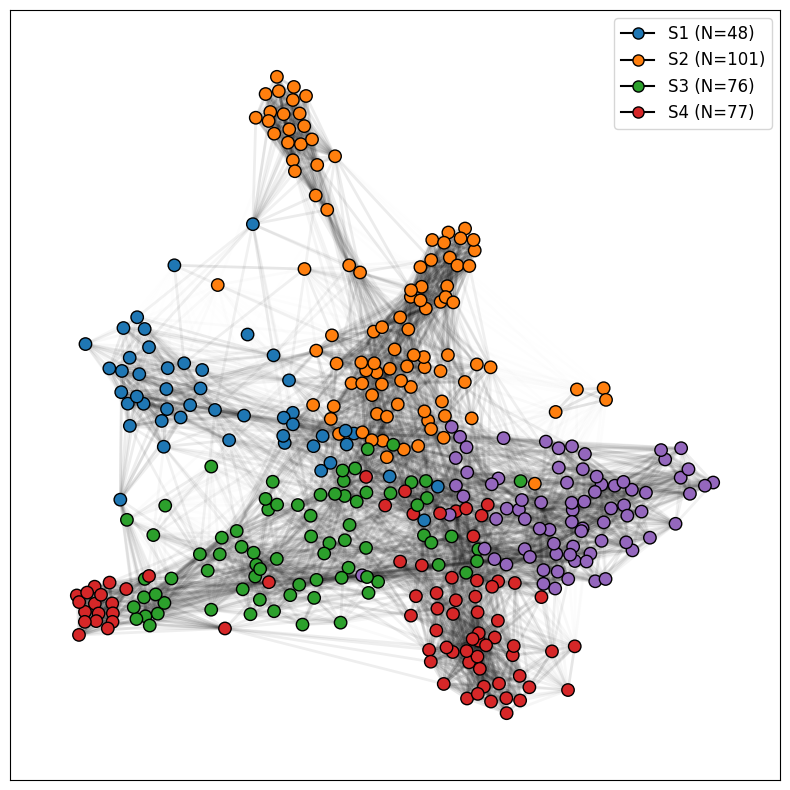

In [219]:
G_population = construct_PopulationGraph(
    Gram_matrix,
    'knn_graph',
    para_dict = {
        'weight_threshold_percentile': 90,
        'knn_k':20
    },
)
color_palette = ["white"] + sns.color_palette("tab10") + sns.color_palette("Set2")
pos = nx.spring_layout(G_population, seed=2, k=1 / np.sqrt(682) * 5, iterations=100)
fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)
edge_list = list(G_population.edges())
edge_alpha = [
        0.1 * G_population[u][v]["weight"] if G_population[u][v]["weight"] > 0 else 0 for u, v in edge_list
    ]
nx.draw_networkx_edges(G_population, pos, alpha=edge_alpha, width=2)
nx.draw_networkx_nodes(
            G_population, pos, node_size=80, 
            node_color=[color_palette[int(i)] for i in Subgroup_ids], 
            edgecolors="black"
        )
if np.sum(Subgroup_ids == 0)>0:
    handles = [
        Line2D(
            [0],
            [0],
            marker="o",
            color = 'k',
            label=f"Unclassified (N={np.sum(Subgroup_ids == 0)})",
            markerfacecolor=color_palette[0],
            markeredgecolor="black",
            markeredgewidth=1,
            markersize=8,
        )
    ]
else:
    handles = []
for i in range(1, len(np.unique(Subgroup_ids))):
    patch = Line2D(
        [0],
        [0],
        marker="o",
        color = 'k',
        label=f"S{i} (N={np.sum(Subgroup_ids == i)})",
        markerfacecolor=color_palette[i],
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    )
    handles.append(patch)
ax.legend(handles=handles, fontsize = 12)
plt.show()

In [521]:
# Histograms_ = (Histograms_ - np.mean(Histograms_, axis=0))/np.std(Histograms_, axis=0)
DF = pd.DataFrame({
    'length': Length_,
    'status': Status_,
})
for pattern_id in Candidates:
    DF["pattern_"+str(pattern_id)] = Histograms_[:, pattern_id]
cph = CoxPHFitter()
cph.fit(DF, duration_col='length', event_col='status', formula=" + ".join(["pattern_"+str(i) for i in Candidates]))
print(cph.print_summary())

<lifelines.CoxPHFitter: fitted with 369 total observations, 189 right-censored observations>
             duration col = 'length'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 369
number of events observed = 180
   partial log-likelihood = -938.75
         time fit was run = 2023-11-03 01:07:38 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
pattern_10  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
pattern_15  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
pattern_16   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
pattern_18   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
pattern_22  -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
pattern_23  -0.00       1.00       0.00            -0.01            -0.00                 0.99                 1.00
pattern_28   0.00       1.00       0.00             0.00             0.01                 1.00                 1.01
pattern_35  -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00

             cmp to     z    p   -log2(p)
covariate                                
pattern_10     0.00 -0.16 0.88       0.19
pattern_15     0.00 -0.92 0.36       1.49
pattern_16     0.00  1.60 0.11       3.20
pattern_18     0.00  0.48 0.63       0.66
pattern_22     0.00 -1.67 0.09       3.40
pattern_23     0.00 -2.08 0.04       4.74
pattern_28     0.00  2.67 0.01       7.04
pattern_35     0.00 -1.84 0.07       3.92
---
Concordance = 0.59
Partial AIC = 1893.49
log-likelihood ratio test = 19.64 on 8 df
-log2(p) of ll-ratio test = 6.41

None
